## Making your own performance metric

In case you want to optimize a metric that is not available in sk

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer


In [8]:
breat_cancer = load_breast_cancer()

In [11]:
X = pd.DataFrame(breat_cancer.data, columns=breat_cancer.feature_names)
y = pd.DataFrame(breat_cancer.target)

In [12]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [20]:
y =y[0].map({0:1, 1:0})

In [21]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: 0, Length: 569, dtype: int64

In [22]:
y.value_counts()/len(y)

0    0.627417
1    0.372583
Name: 0, dtype: float64

## Confusion matrix

We will use the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
) function from sklearn to return the false positive, false negatives, true positives and true negatives, to construct the false negative rate.


TN | FP

FN | TP

## False Negative Rate

Because it is a dangerous disease, I want to minimize the number of false negatives cases (the false negative rate). That is, I want to minimize the number of cases where the tumor in a patient is malign (1) and it is wrongly classified as benign (0). This way, we can offer treatment to as many patients as possible.

Because the **False Negative Rate** is not a metric available in sklearn, we need to create a function ourselves.

We will use the [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function from sklearn:

In [23]:
# funstion 
def fnr(y_true, y_pred):
    tn, fp, fn, tp  = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    FNR = fn/(tp+fn)
    return FNR

In [24]:
fnr_score= make_scorer(fnr, 
                      greater_is_better=False, 
                      needs_proba=False)

In [25]:
rf_model = RandomForestClassifier(n_estimators=100,
                                 max_depth=1, random_state=0, 
                                 n_jobs=-1)
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4],
)

In [26]:
clf = GridSearchCV(rf_model, rf_param_grid, scoring=fnr_score,
                  cv=5)

In [27]:
search = clf.fit(X, y)

In [28]:
search.best_params_

{'max_depth': 3, 'n_estimators': 200}

In [29]:
import joblib

In [31]:
joblib.dump(search, 'model_grid_search.pkl')

['model_grid_search.pkl']

In [32]:
search.cv_results_

{'mean_fit_time': array([0.82284064, 0.09791327, 0.21812105, 0.37256021, 0.80546927,
        1.92692208, 4.25525012, 7.12025261, 0.05929494, 0.10358424,
        0.23150468, 0.37215638, 0.75507298, 1.64612451, 3.47350283,
        6.81757145, 0.05770311, 0.1003974 , 0.22073455, 0.41097326,
        0.76903977, 1.76304193, 3.87497301, 6.73174248, 0.0684278 ,
        0.10673213, 0.2424489 , 0.44533548, 0.77462659, 1.7770092 ,
        3.47989874, 6.8242146 ]),
 'std_fit_time': array([1.52602186, 0.00863218, 0.01029765, 0.01259662, 0.14729925,
        0.32128156, 0.94485368, 1.38262002, 0.00376058, 0.01131553,
        0.01324052, 0.00763118, 0.06591261, 0.04739787, 0.4404863 ,
        0.50060083, 0.0060443 , 0.01051719, 0.01080916, 0.05099138,
        0.05712269, 0.09043024, 0.59497883, 0.18625728, 0.00799999,
        0.0079507 , 0.02416521, 0.014056  , 0.01394946, 0.02007968,
        0.06182253, 0.08835631]),
 'mean_score_time': array([0.02349443, 0.01875429, 0.02977605, 0.04938045, 0.096429

In [34]:
pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",-0.164563,0.068712
1,"{'max_depth': 1, 'n_estimators': 20}",-0.159801,0.073267
2,"{'max_depth': 1, 'n_estimators': 50}",-0.178627,0.068895
3,"{'max_depth': 1, 'n_estimators': 100}",-0.145404,0.085822
4,"{'max_depth': 1, 'n_estimators': 200}",-0.140642,0.082462
5,"{'max_depth': 1, 'n_estimators': 500}",-0.140642,0.086489
6,"{'max_depth': 1, 'n_estimators': 1000}",-0.150055,0.088251
7,"{'max_depth': 1, 'n_estimators': 2000}",-0.145404,0.080364
8,"{'max_depth': 2, 'n_estimators': 10}",-0.121927,0.073512
9,"{'max_depth': 2, 'n_estimators': 20}",-0.103433,0.034071


In [35]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

In [36]:
results.sort_values(by='mean_test_score',
                   ascending=False, inplace=True)

In [37]:
results.reset_index(drop=True, inplace=True)

Text(0.5, 0, 'Hyperparameter space')

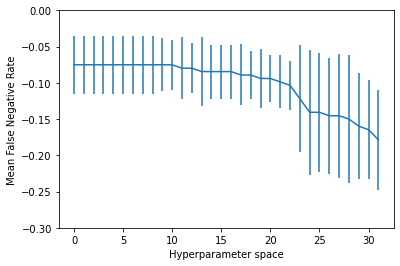

In [43]:
results['mean_test_score'].plot(yerr=[results['std_test_score'],
                                     results['std_test_score']], subplots=True)
plt.ylim(-0.3,0)
plt.ylabel('Mean False Negative Rate')
plt.xlabel('Hyperparameter space')

## Scoring Function that needs a probability

In [47]:
def fnr(y_true, y_pred):
    y_pred_classes = np.where(y_pred>0.37, 0, 1)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_classes,
                                        labels=[0,1]).ravel()
    FNR = fn/(tp+fn)
    return FNR

In [48]:
fnr_score = make_scorer(fnr,
                       greater_is_better=False,
                       needs_proba=True)

In [49]:
# random forests
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=1, random_state=0, n_jobs=4)

# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4],
)

# search
clf = GridSearchCV(rf_model,
                   rf_param_grid,
                   scoring=fnr_score,
                   cv=5)

search = clf.fit(X, y)

# best hyperparameters
search.best_params_

{'max_depth': 1, 'n_estimators': 10}

Text(0.5, 0, 'Hyperparameter space')

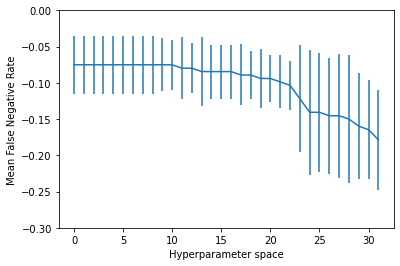

In [50]:
esults = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylim(-0.3, 0)
plt.ylabel('Mean False Negative Rate')
plt.xlabel('Hyperparameter space')

### Optimizing a performance metric

In this notebook, we are going to see how we can optimize a metric in a grid search for hyperparameters utilizing sklearn.


In [51]:
# search
clf = GridSearchCV(rf_model,
                   rf_param_grid,
                   scoring='roc_auc',
                   cv=5)

In [52]:
search_roc = clf.fit(X, y)

In [53]:
joblib.dump(search_roc, 'search_roc.pkl')

['search_roc.pkl']

In [54]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

results.head()

,params,mean_test_score,std_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",-0.905980,0.038729
1,"{'max_depth': 1, 'n_estimators': 20}",-0.920377,0.053959
2,"{'max_depth': 1, 'n_estimators': 50}",-0.925249,0.067868
3,"{'max_depth': 1, 'n_estimators': 100}",-0.906534,0.078948
4,"{'max_depth': 1, 'n_estimators': 200}",-0.920487,0.063125


Text(0.5, 0, 'Hyperparameter space')

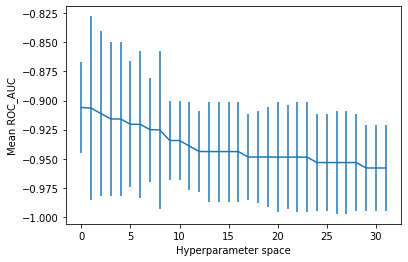

In [55]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean ROC_AUC')
plt.xlabel('Hyperparameter space')

In [ ]:
 22